Version 1.4

Last updated: 2022-01-27

# Probabilistic ML: Assignment 1
- **Deadline**: Feb 6, at 23:59.
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. LATEX, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.


# Q1 - Decision Theory

One successful use of probabilistic models is for building spam filters, which take in an email and take different actions depending on the likelihood that it’s spam.

Imagine you are running an email service. You have a well-calibrated spam classifier that tells you the probability that a particular email is spam: $p(spam|email)$. You have three options for what to do with each email: You can show it to the user, put it in the spam folder, or delete it entirely.

Depending on whether or not the email really is spam, the user will suffer a different amount  of wasted time for the different actions we can take, $L$(action, spam):

Action   | Spam        | Not spam
-------- | ----------- | -----------
Show     | 10          | 0
Folder   | 1           | 50
Delete   | 0           | 200

## Q1.1
[3pts] Plot the expected wasted user time for each of the three possible actions, as a function of the probability of spam: $p(spam|email)$.

In [104]:
import numpy as np
import matplotlib.pyplot as plt

0
1
2


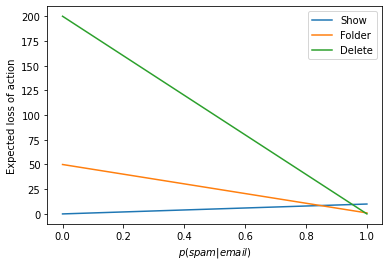

In [105]:
losses = [[10, 0], [1, 50],[0, 200]]
actions_names = ['Show', 'Folder', 'Delete']
num_actions = len(losses)
def expected_loss_of_action(prob_spam, action):
    #TODO: Return expected loss over a Bernoulli random variable
    # with mean prob_spam.
    # Losses are given by the table above.
    E_loss = prob_spam * losses[action][0] + (1 - prob_spam) * losses[action][1]
    return E_loss

prob_range = np.linspace(0., 1., num=500) 

# Make plot
for action in range(num_actions):
    print(action)
    plt.plot(prob_range, expected_loss_of_action(prob_range, action), label=actions_names[action])

plt.xlabel('$p(spam|email)$')
plt.ylabel('Expected loss of action')
plt.legend()


## Q1.2
[2pts] Write a function that computes the optimal action given the probability of spam.

In [106]:
def optimal_action(prob_spam):
    #TODO: return best action given the probability of spam. 
    #Hint: np.argmin might be helpful.
    arr = []
    for action in range(num_actions):
      arr.append(expected_loss_of_action(prob_spam, action))
    return np.argmin(arr)

## Q1.3
[4pts] Plot the expected loss of the optimal action as a function of the probability of spam.


**[Optional]** Color the line according to the optimal action for that probability of spam.


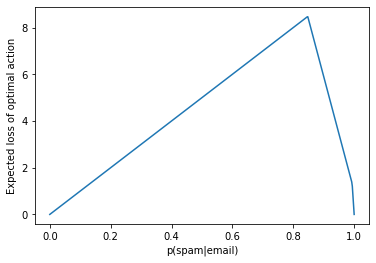

In [108]:
prob_range = np.linspace(0., 1., num=500) 
optimal_losses = []
optimal_actions = []
for p in prob_range:
    # TODO: Compute the optimal action and its expected loss for
    # probability of spam given by p.
    opt_action = optimal_action(p)
    optimal_actions.append(opt_action)
    optimal_losses.append(expected_loss_of_action(p, opt_action))

plt.xlabel('p(spam|email)')
plt.ylabel('Expected loss of optimal action')
plt.plot(prob_range, optimal_losses)

## Q1.4
[4pts] For exactly which range of the probabilities of an email being spam should we delete an email?

Find the exact answer by hand using algebra.

[Type up your derivation here]

Your answer:

solve for $p$ when $E_t[L(Folder|t)] > E_t[L(Delete|t)]$

$\implies pL(Folder|t=spam)+(1-p)L(Folder|t\neq spam) > pL(Delete|t=spam)+(1-p)L(Delete|t\neq spam)$

$\implies p+50(1-p)>200(1-p)$

$\implies 151p>150$

$\implies p>\frac{150}{151}$

so we should delete the email if $p\in (\frac{150}{151}, 1]$

# Q2 - Naïve Bayes, A Generative Model

In this question, we'll fit a Naïve Bayes model to the MNIST digits dataset, and use this model for making predictions and generating new images from the same distribution. MNIST is a dataset of 28x28 black-and-white images of handwritten digits of 0 to 9. We represent each image by a vector $x^{(i)} \in \{0,1\}^{784}$, where 0 and 1 represent white and black pixels respectively. Each class label $c^{(i)}$ is a number between 0 and 9, which in the code is represented by a 10-dimensional one-hot vector.

![](https://drive.google.com/uc?id=15UvN6-AZj92QDmbl60Q-zR_YTIukx9SO)


The Naïve Bayes model parameterized by $\theta$ and $\pi$ defines the following joint probability of $x$ and $c$,
$$p(x,c|\theta,\pi) = p(c|\pi)p(x|c,\theta) = p(c|\pi)\prod_{j=1}^{784}p(x_j|c,\theta),$$
where $x_j | c,\theta \sim \operatorname{Bernoulli}(\theta_{jc})$ or in other words $p(x_j | c,\theta) = \theta_{jc}^{x_j}(1-\theta_{jc})^{1-x_j}$, and $c|\pi$ follows a simple categorical distribution, i.e. $p(c|\pi) = \pi_c$.

We begin by learning the parameters $\theta$ and $\pi$. The following code will download and prepare the training and test sets.

In [109]:
import numpy as np
import os
import gzip
import struct
import array
import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def mnist():
    base_url = 'http://yann.lecun.com/exdb/mnist/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels = parse_labels('data/t10k-labels-idx1-ubyte.gz')

    return train_images, train_labels, test_images[:1000], test_labels[:1000]


def load_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels

## Q2.1
[2pts] Derive the expression for the Maximum Likelihood Estimator (MLE) of $\theta$ and $\pi$.

[Type up your derivation here]

Your answer:
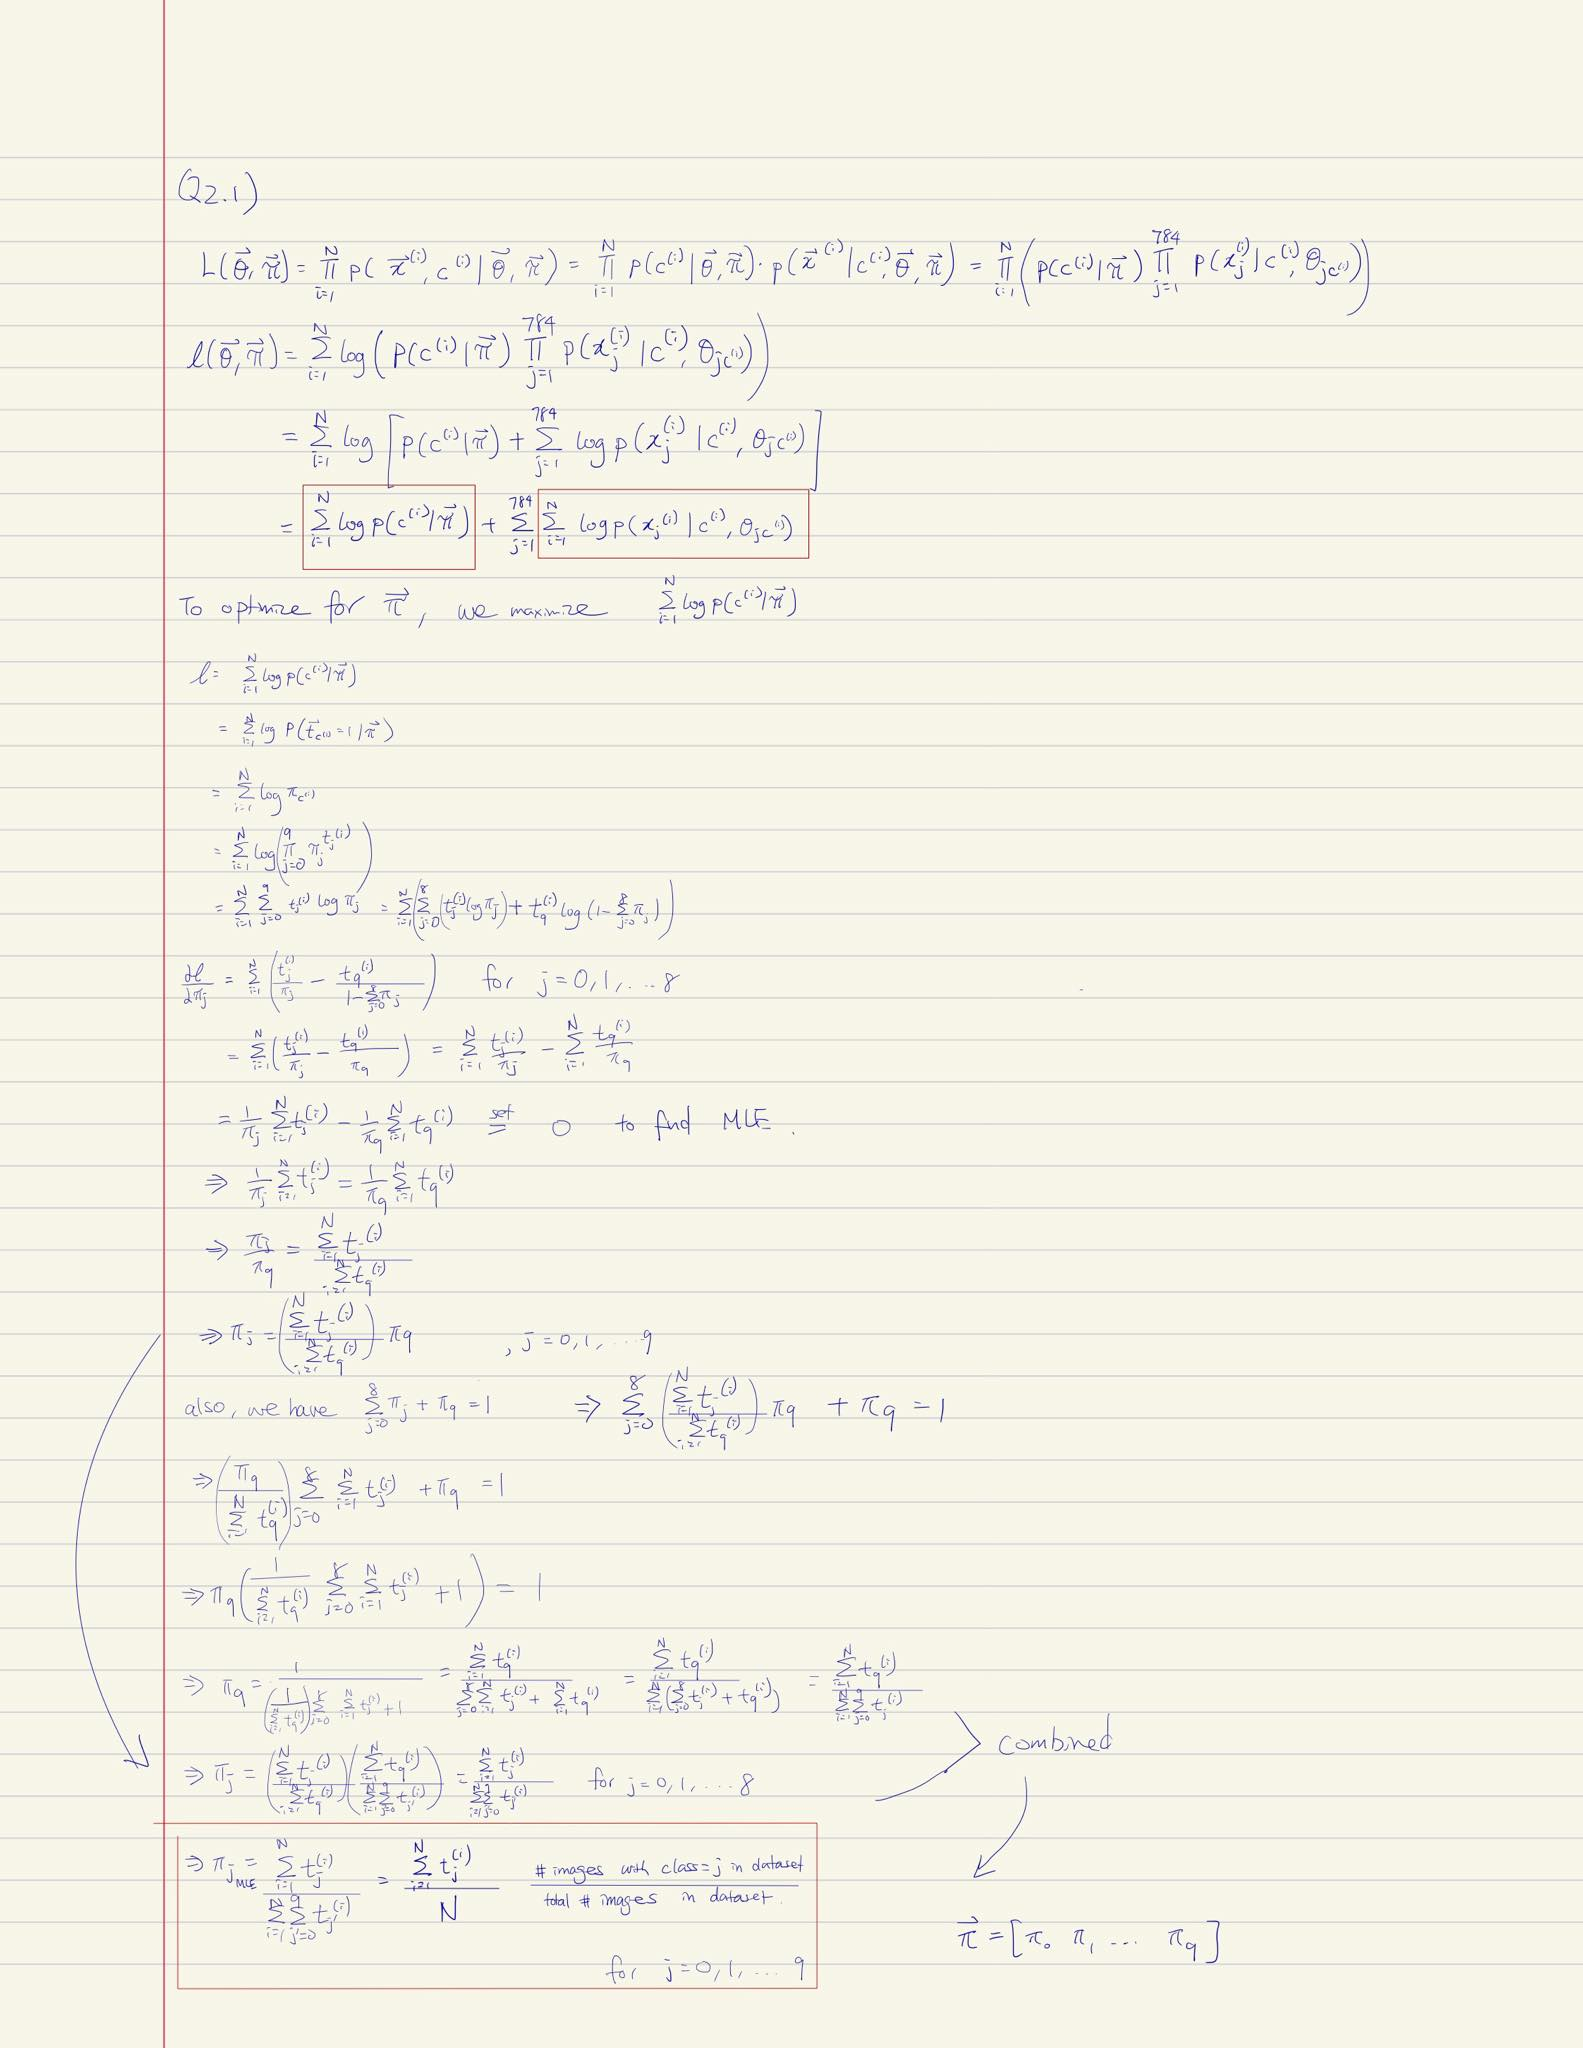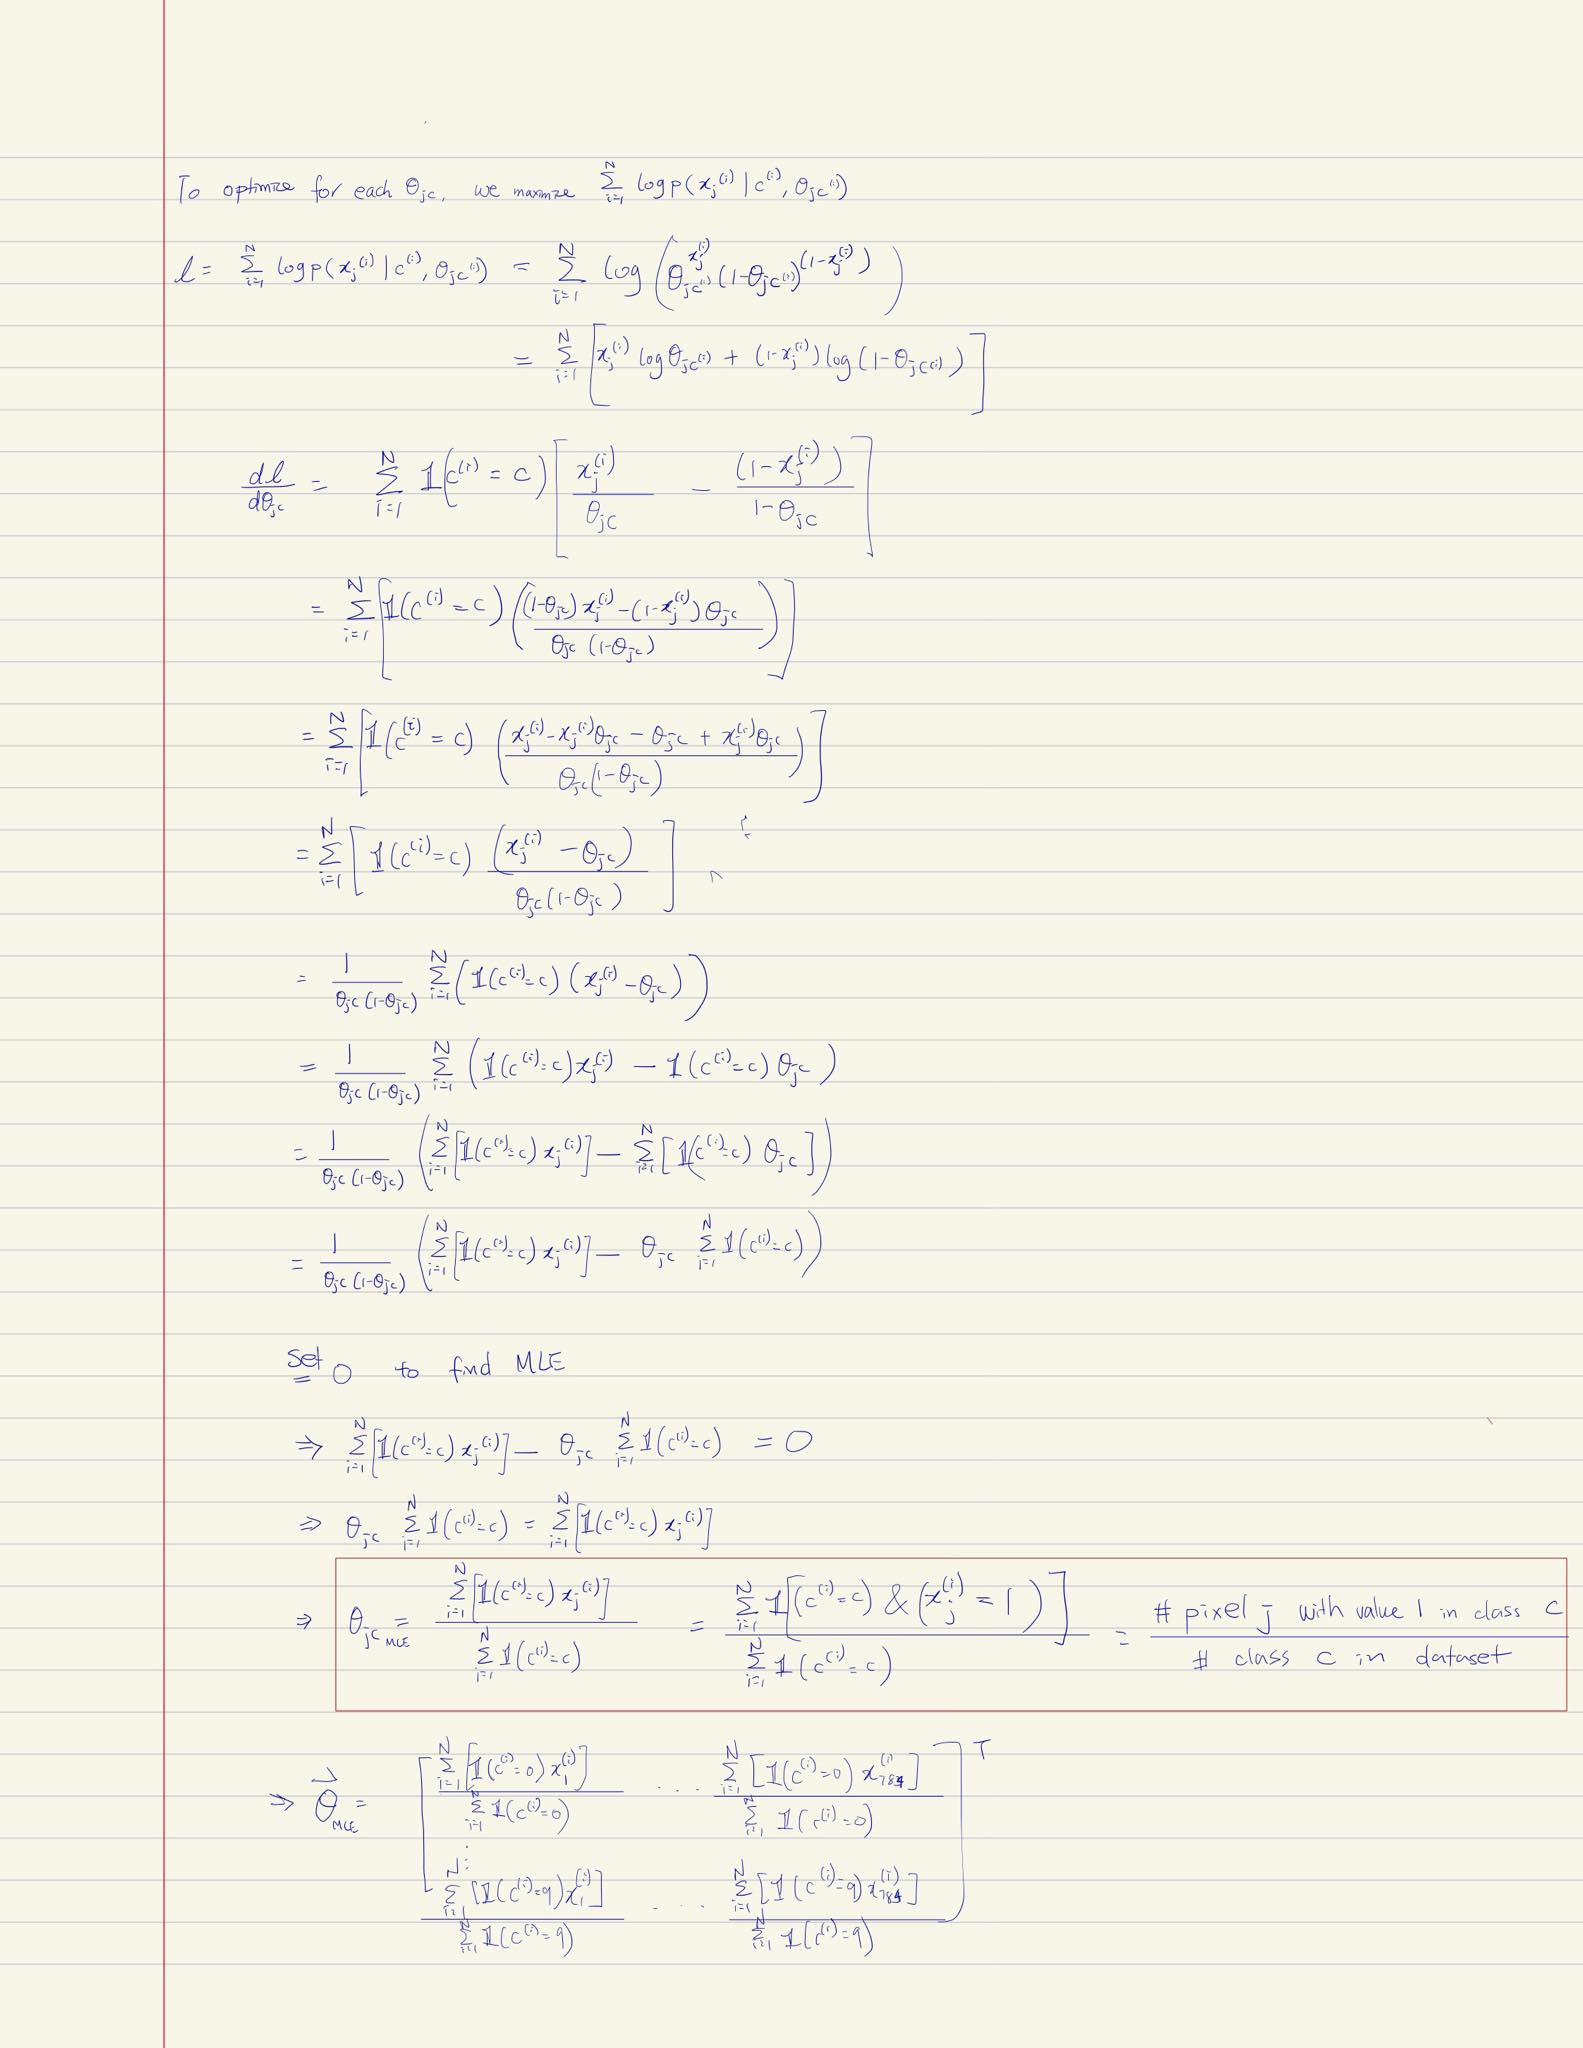

## Q2.2
[4pts] Using the MLE for this data, many entries of $\theta$ will be estimated to be 0, which seems extreme. So we look for another estimation method.

Assume the prior distribution of $\theta$ is such that the entries are i.i.d. and drawn from $\operatorname{Beta}(2,2)$. Derive the Maximum A Posteriori (MAP) estimator for $\theta$ (it has a simple final form). You can return the MLE for $\pi$ in your implementation. From now on, we will work with this estimator.

[Type up your derivation here]

Your answer:
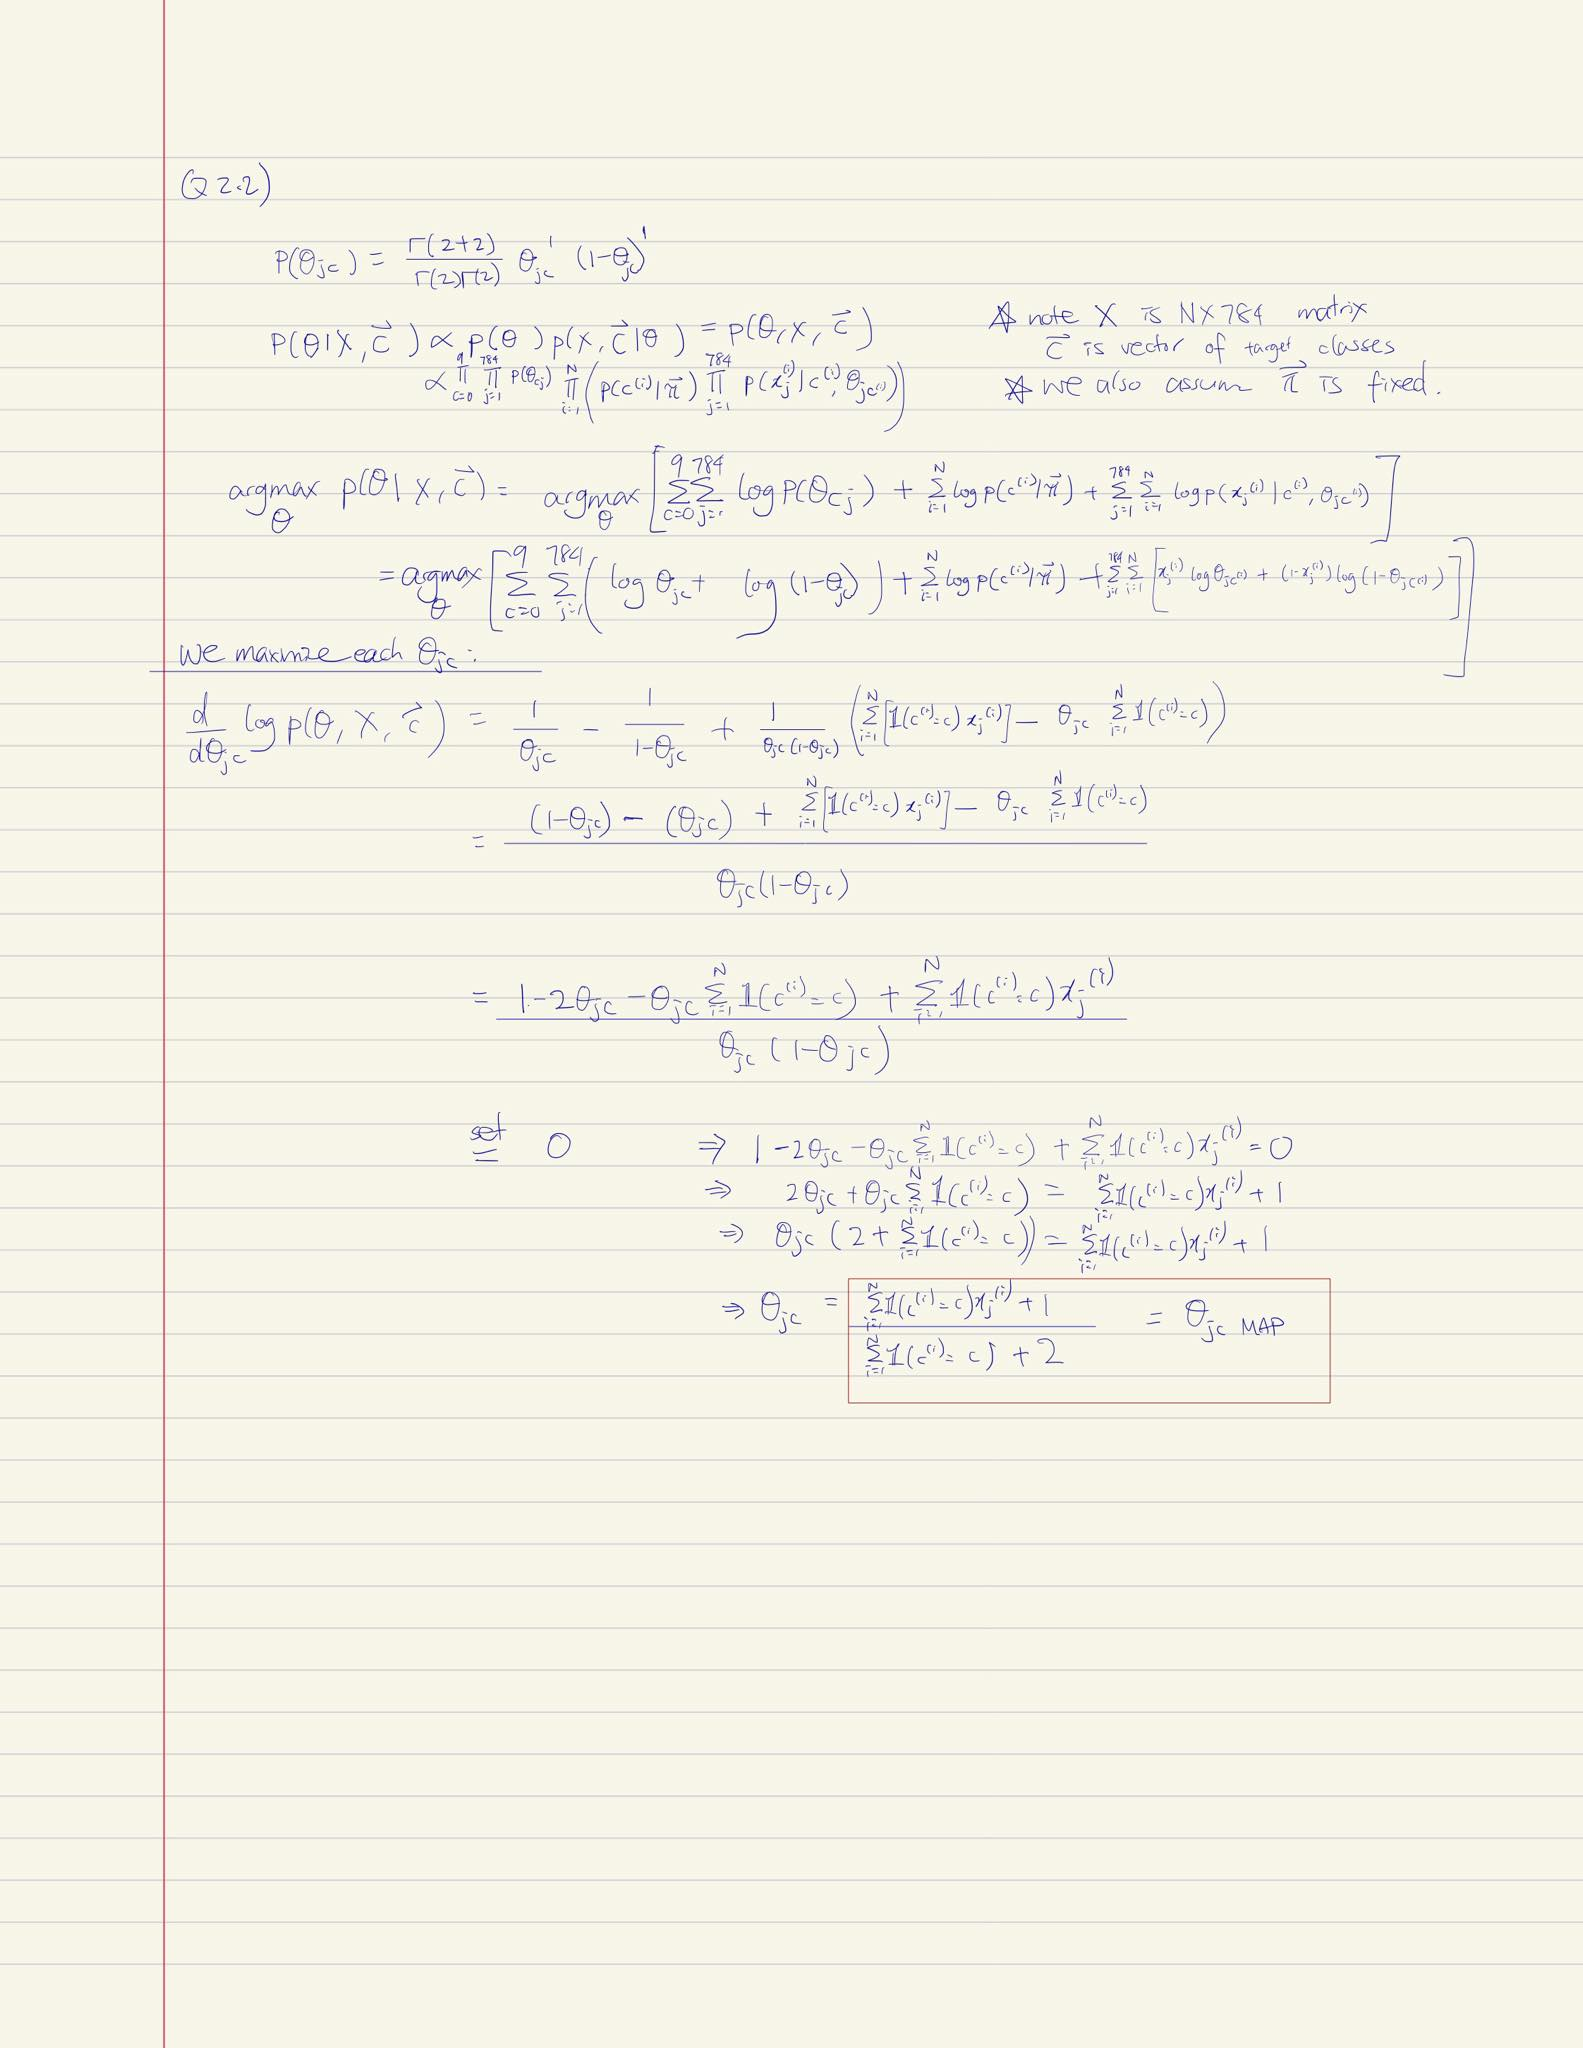

In [110]:
def train_map_estimator(train_images, train_labels):
    """ Inputs: train_images (N_samples x N_features), train_labels (N_samples x N_classes)
        Returns the MAP estimator theta_est (N_features x N_classes) and the MLE
        estimator pi_est (N_classes)"""
    
    # YOU NEED TO WRITE THIS PART
    N = len(train_labels)
    C = train_labels.sum(axis=0).reshape([-1, 1])
    theta_est = (((train_labels.T @ train_images) + 1) / (C + 2)).T
    pi_est = (C/float(N)).T
    return theta_est, pi_est

## Q2.3
[5pts] Derive an expression for the class log-posterior $\log p(c|x,\theta,\pi)$ for a single image. Then, complete the implementation of the following functions. Recall that our prediction rule is to choose the class that maximizes the above posterior, and accuracy is defined as the fraction of samples that are correctly predicted.

Report the average log-posterior $\frac{1}{N}\sum_{i=1}^{N}\log p(c^{(i)}|x^{(i)},\hat{\theta},\hat{\pi})$ (where $N$ is the number of samples) on the training test, as well the training and test errors.

[Type up your derivation here]

Your answer:
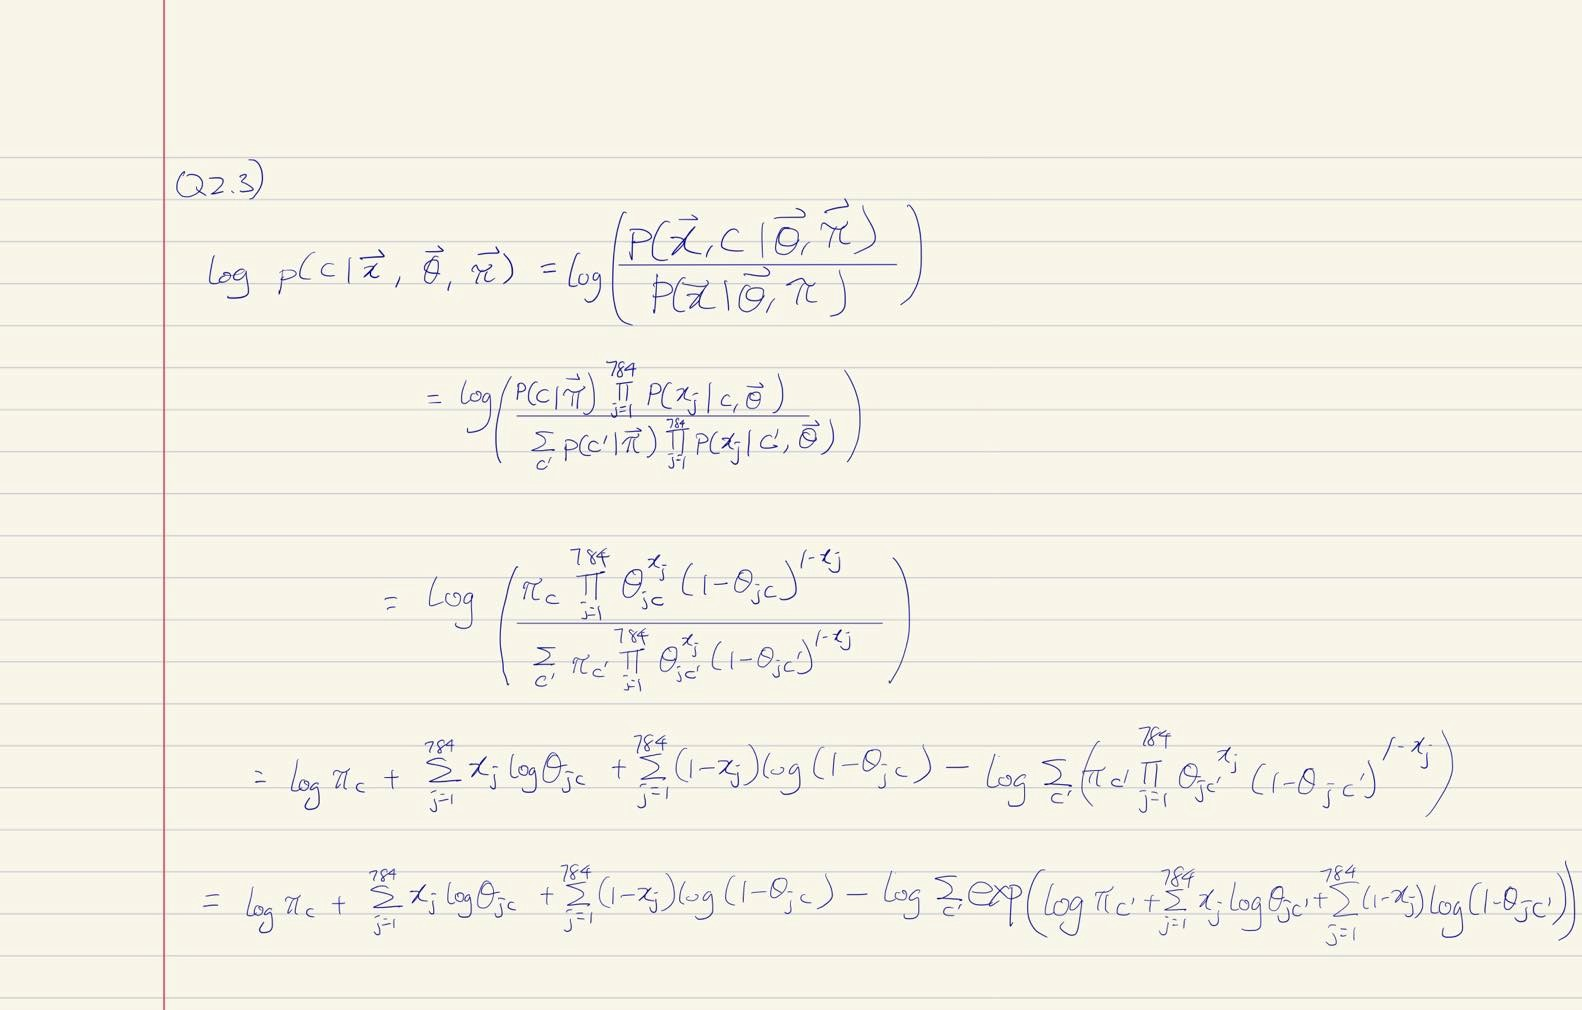

In [111]:

def log_likelihood(images, theta, pi):
    """ Inputs: images (N_samples x N_features), theta, pi
        Returns the matrix 'log_like' of loglikehoods over the input images where
        log_like[i,c] = log p (c |x^(i), theta, pi) using the estimators theta and pi.
        log_like is a matrix of (N_samples x N_classes)
    Note that log likelihood is not only for c^(i), it is for all possible c's."""

    # YOU NEED TO WRITE THIS PART
    a = np.log(pi) + images @ np.log(theta) + (1 - images) @ np.log(1 - theta)
    b = np.log((np.exp(a)).sum(axis=1)).reshape((-1, 1))
    log_like = a - b
    return log_like


def accuracy(log_like, labels):
    """ Inputs: matrix of log likelihoods and 1-of-K labels (N_samples x N_classes)
    Returns the accuracy based on predictions from log likelihood values"""

    # YOU NEED TO WRITE THIS PART
    predictions = (np.argmax(log_like, axis=1)).reshape((-1, 1))
    labels = np.argmax(labels, axis=1).reshape((-1, 1))
    accuracy = np.mean(predictions == labels)
    return accuracy


N_data, train_images, train_labels, test_images, test_labels = load_mnist()
theta_est, pi_est = train_map_estimator(train_images, train_labels)


loglike_train = log_likelihood(train_images, theta_est, pi_est)
avg_loglike = np.sum(loglike_train * train_labels) / N_data
train_accuracy = accuracy(loglike_train, train_labels)
loglike_test = log_likelihood(test_images, theta_est, pi_est)
test_accuracy = accuracy(loglike_test, test_labels)

print(f"Average log-likelihood for MAP is {avg_loglike:.3f}")
print(f"Training accuracy for MAP is {train_accuracy:.3f}")
print(f"Test accuracy for MAP is {test_accuracy:.3f}")

Average log-likelihood for MAP is -3.356
Training accuracy for MAP is 0.836
Test accuracy for MAP is 0.816


## Q2.4
[2pts] In this model, is it always true that any two pixels $x_i$ and $x_j$ with $i \neq j$ are independent given $c$? How about after marginalizing over $c$? Explain your answers.

[Type up your answer here]

Your answer:

Yes, our model assumes that anny two pixels $x_i$ and $x_j$ with $i \neq j$ are independent given $c$ because we assumed that

$$p(x|c,\theta) = \prod_{j=1}^{784}p(x_j|c,\theta)$$

However, this does not mean that $x_i$ and $x_j$ are not independent in general (i.e. they are not independent after margenalizing over $c$.)

$$p(x|\theta) \neq \prod_{j=1}^{784}p(x_j|\theta)$$ 


## Q2.5 
[4pts] Since we have a generative model for our data, we can do more than just prediction. Randomly sample and plot 10 images from the learned distribution over images using the MAP parameter estimates. (Hint: You first need to sample the class $c$, and then sample pixels conditioned on $c$.)

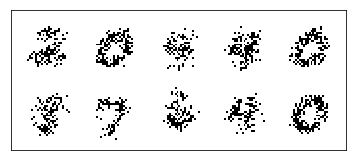

In [113]:
def image_sampler(theta, pi, num_images):
    """ Inputs: parameters theta and pi, and number of images to sample
    Returns the sampled images (N_images x N_features)"""

    # YOU NEED TO WRITE THIS PART
    lst = [i for i in range(10)]
    sampled_images = []
    for i in range(num_images):
      c = np.random.choice(lst)
      x = np.random.binomial(1, theta.T[c])
      sampled_images.append(x)
    return np.asarray(sampled_images)


def plot_images(images, ims_per_row=5, padding=5, digit_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=0., vmax=1.):
    """Images should be a (N_images x pixels) matrix."""
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)

    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = vmin
    concat_images = np.full(((digit_dimensions[0] + padding) * N_rows + padding,
                             (digit_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], digit_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + digit_dimensions[0]) * row_ix
        col_start = padding + (padding + digit_dimensions[1]) * col_ix
        concat_images[row_start: row_start + digit_dimensions[0],
                      col_start: col_start + digit_dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    
    plt.plot()


sampled_images = image_sampler(theta_est, pi_est, 10)
plot_images(sampled_images)

## Q2.6
[4pts] One of the advantages of generative models is that they can handle missing data, or be used to answer different sorts of questions about the model. Assume we have only observed some pixels of the image. Let $x_E = \{x_p : \text{pixel $p$ is observed}\}$. Derive an expression for $p(x_j|x_E,\theta,\pi)$, the conditional probability of an unobserved pixel $j$ given the observed pixels and distribution parameters. (Hint: You have to marginalize over $c$.)

[Type up your derivation here]

Your answer:
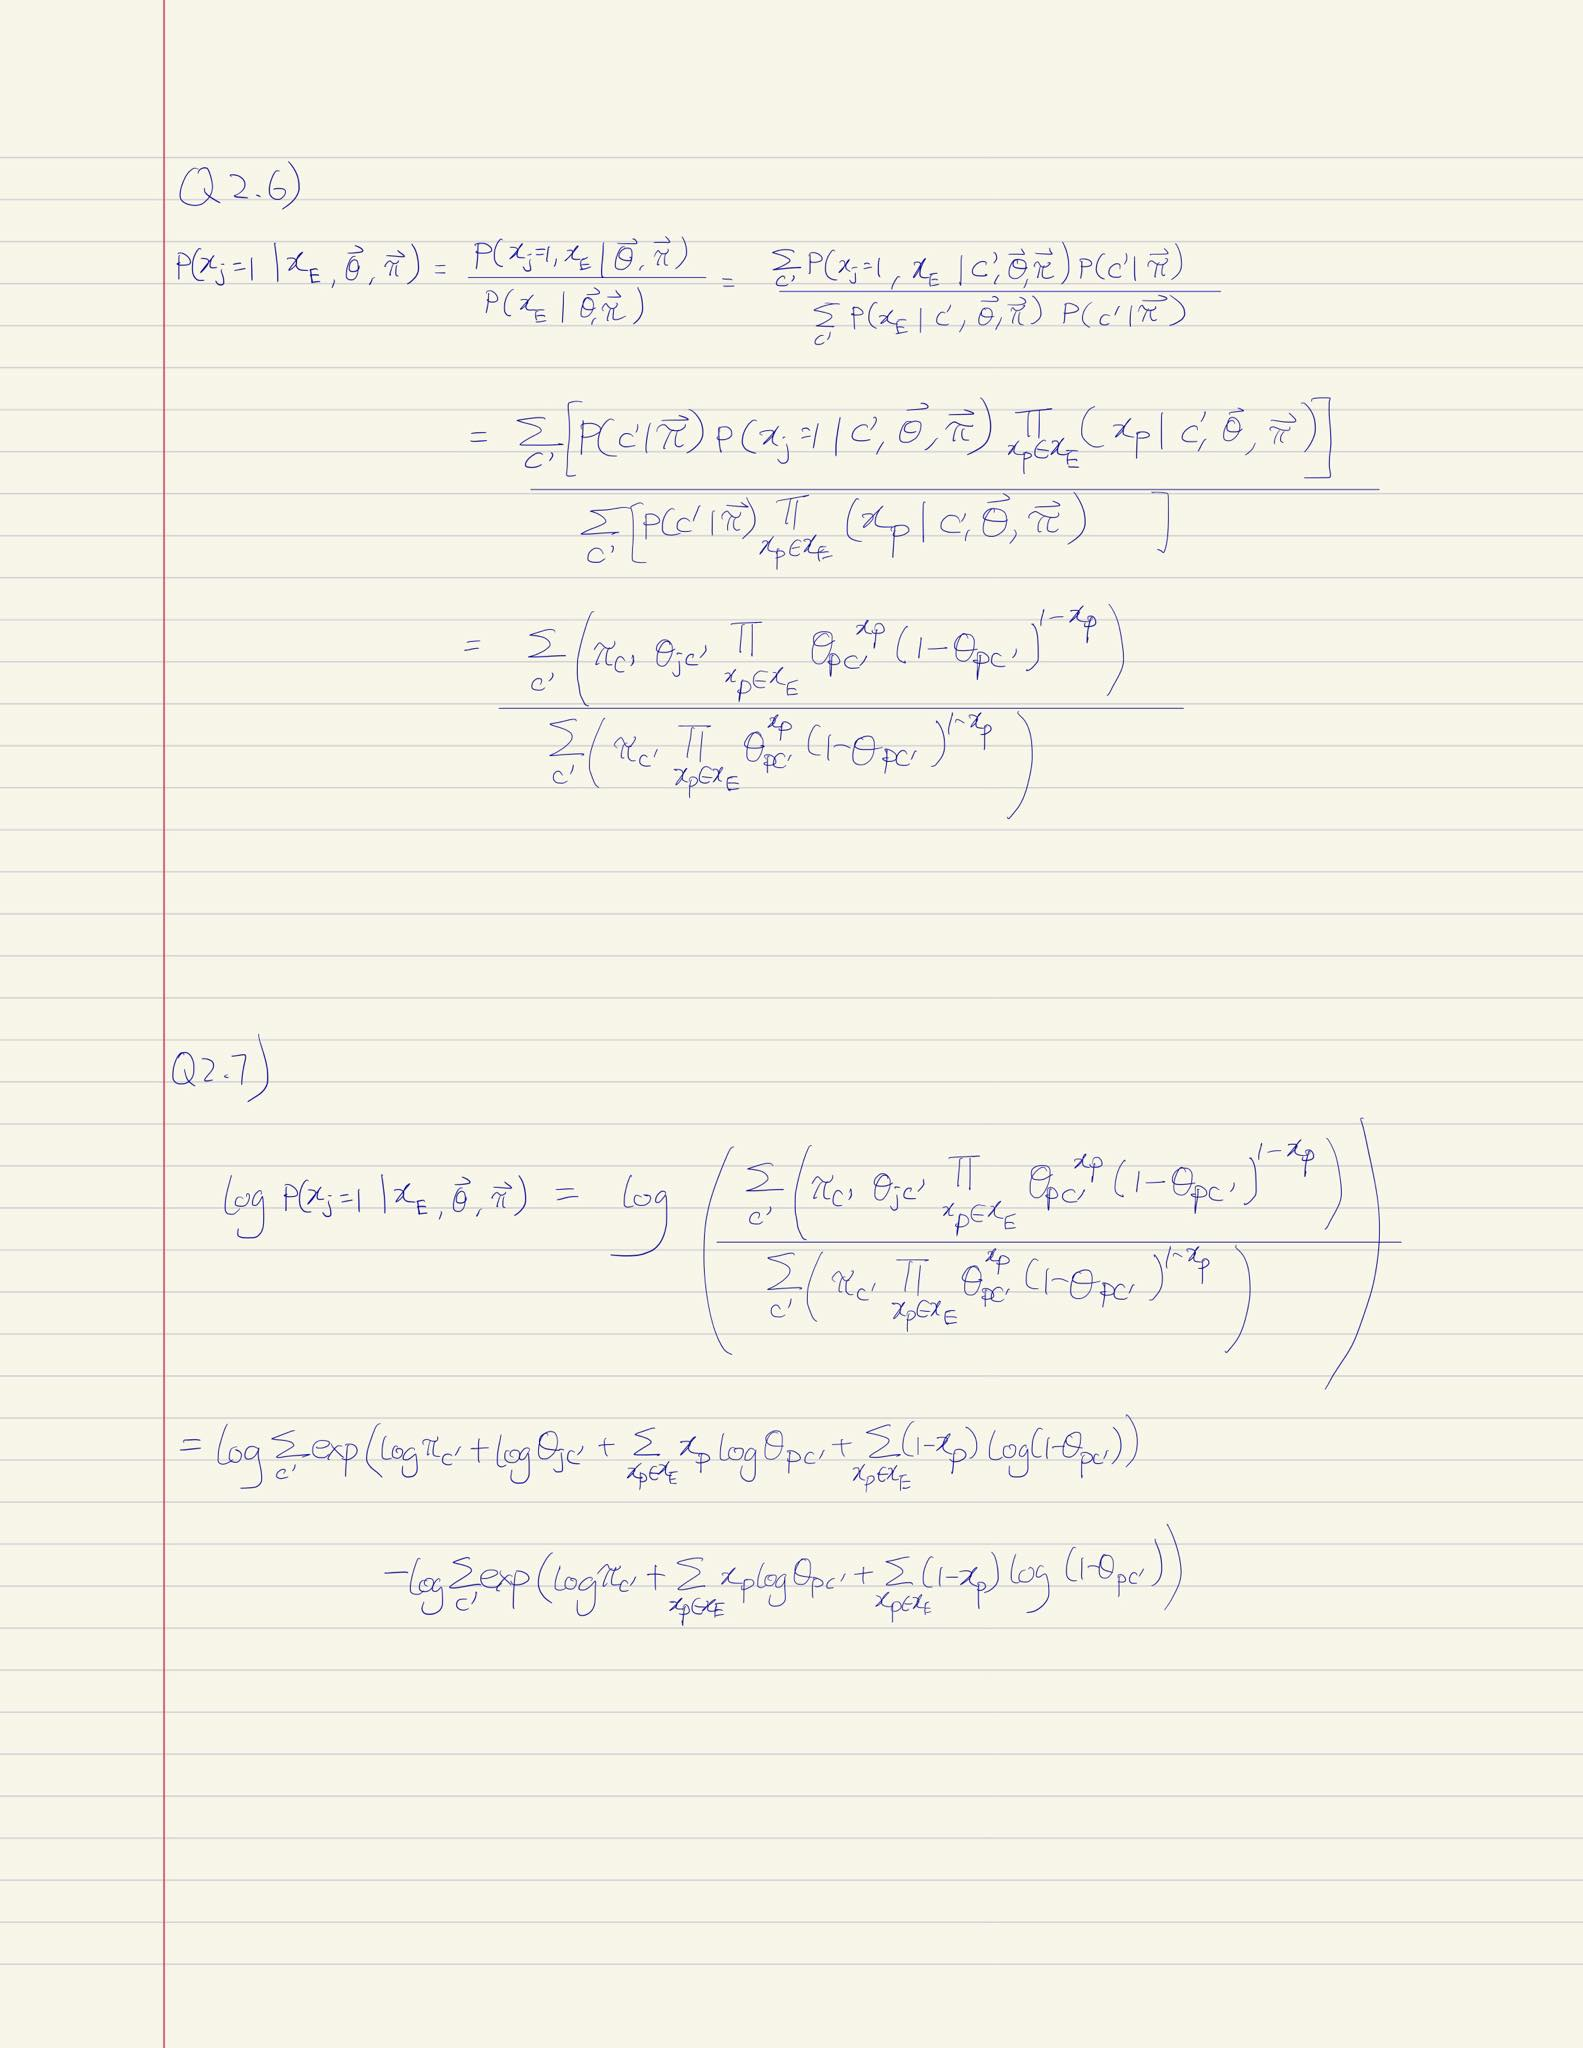

## Q2.7
[4pts] We now reveal only a random 20% of the pixels to the model. For the first 20 images in the training set, plot the images when the unobserved pixels are left as white, as well as the same images when the unobserved pixels are filled with the marginal probability of each pixel being 1 given the observed pixels, i.e. the value of the unobserved pixel $j$ is $p(x_j = 1|x_E,\theta,\pi)$.

Hint: You should compute log-probabilities instead of probabilities to avoid underflow, then convert to probabilities only at the last step.  You might also want to use `jnp.logsumexp` whenever you have a log of a sum of probabilities, to avoid numerical instability.

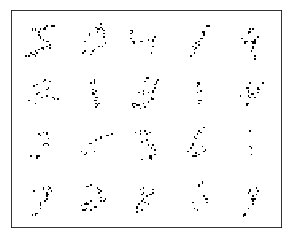

In [114]:
from jax.scipy.special import logsumexp
#from scipy.special import logsumexp

def probabilistic_imputer(theta, pi, original_images, is_observed):
    """Inputs: parameters theta and pi, original_images (N_images x N_features), 
        and is_observed which has the same shape as original_images, with a value
        1. in every observed entry and 0. in every unobserved entry.
    Returns the new images where unobserved pixels are replaced by their 
    conditional probability"""
    
    # YOU NEED TO WRITE THIS PART
    N_images, N_features = original_images.shape
    inferred = np.zeros([N_images, N_features])
    X_e = original_images * is_observed
    A = (is_observed * original_images) @ np.log(theta) + (is_observed * (1 - original_images)) @ np.log(1 - theta) # Nx10
    for i in range(20):
      for j in range(N_features):
        num = logsumexp(np.log(pi) + np.log(theta[j]) + A[i], axis = 1)
        den = logsumexp(np.log(pi) + A[i], axis = 1)
        diff = num-den
        p = np.exp(diff)
        inferred[i][j] = p
    
    inferred = inferred * (1 - is_observed)
    imputed_images = X_e + inferred
    return imputed_images


num_features = train_images.shape[1]
is_observed = np.random.binomial(1, p=0.2, size=(20, num_features))
plot_images(train_images[:20] * is_observed)

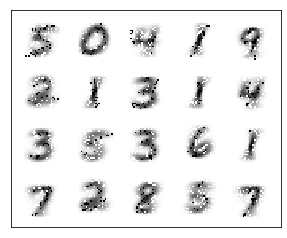

In [115]:
imputed_images = probabilistic_imputer(theta_est, pi_est, train_images[:20], is_observed)
plot_images(imputed_images)

# Q3: Regression [33 pts]



## 3.1 Manually Derived Linear Regression [10 pts]

Suppose that $X \in \mathbb{R}^{m \times n}$ with $n \ge m$ and $Y \in \mathbb{R}^n$, and that $Y \sim \mathcal{N}(X^\top\beta, \sigma^2I)$.

In this question you will derive the result that the maximum likelihood estimate $\hat{\beta}$ of $\beta$ is given

$$\hat{\beta} = (XX^\top)^{-1}XY$$

1. [1 pts] What happens in this estimator if $n < m$?

if $n < m$, then $XX^\top$ is not invertible.
2. [2 pts] What are the expectation and covariance matrix of $\hat{\beta}$ for a given value of $X$ and $\beta$?  Hint:  The mean and covariance of a $\mathcal{N}(\mu, \Sigma)$ variable transformed by matrix $A$ is has distribution $\mathcal{N}(A \mu, A \Sigma A^T)$.

$$E[\hat{\beta}] = (XX^\top)^{-1}X E(Y)$$
$$= (XX^\top)^{-1} XX^\top\beta = \beta$$

$$Var[\hat{\beta}] = (XX^\top)^{-1}X(\sigma^2I)((XX^\top)^{-1}X)^\top$$
$$=(XX^\top)^{-1}X(\sigma^2)X^\top((XX^\top)^{-1})^\top$$
$$= (XX^\top)^{-1}X(\sigma^2)X^\top((XX^\top)^\top)^{-1}$$
$$= (XX^\top)^{-1}(\sigma^2)XX^\top(XX^\top)^{-1}$$
$$=\sigma^2 (XX^\top)^{-1}$$
3. [2 pts] Show that maximizing the likelihood is equivalent to minimizing the squared error $\sum_{i=1}^n(y_i - x_i^T\beta)^2$. [Hint: Use $\sum_{i=1}^na_i^2 = a^\top a]$.
4. [2 pts] Write the squared error in vector notation and expand. [Hint: Use $\beta^\top X^\top Y = Y^\top X \beta$.]
5. [3 pts] Use the likelihood expression to write the negative log-likelihood. Write the derivative of the negative log-likelihood with respect to $\beta$, set equal to zero, and solve to show the maximum likelihood estimate $\hat{\beta}$ as above.

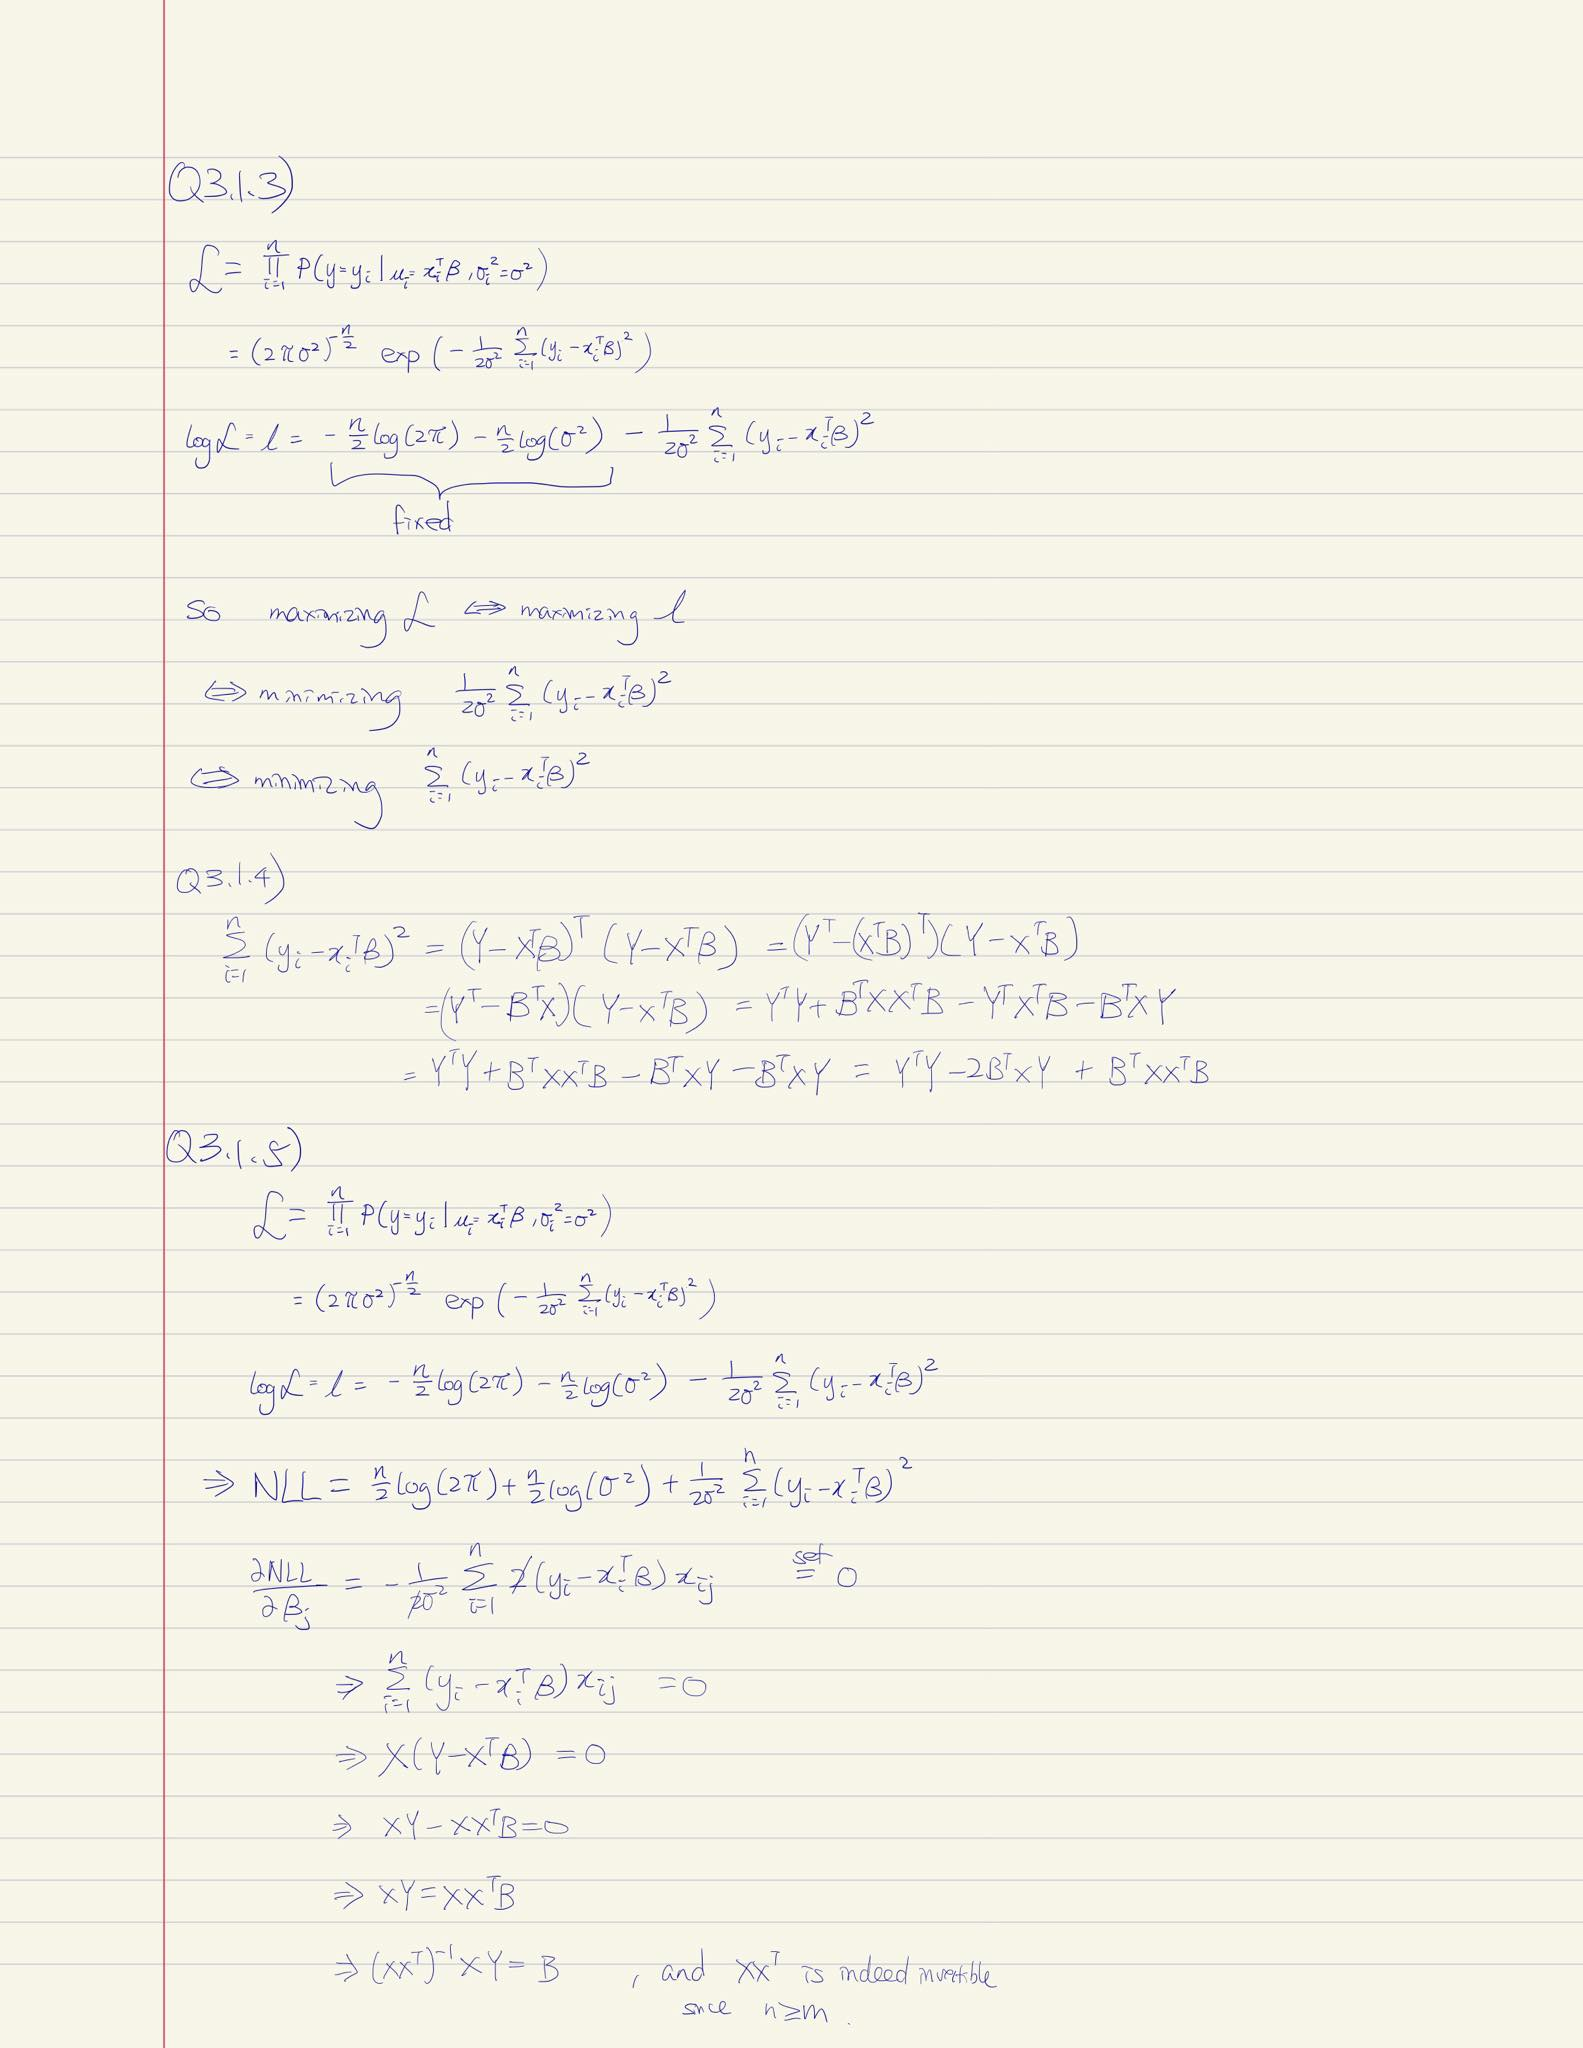

## 3.2 Toy Data [3 pts]

### Note: For this question, we will use [JAX](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html). JAX is a machine learning framework with an API almost identical to numpy. JAX has the benefit of implementing automatic differentiation, which we will use later in this question.

For visualization purposes and to minimize computational resources, we will work with 1-dimensional toy data.

That is, $X \in \mathbb{R}^{m \times n}$ where $m = 1$. We will learn models for 3 target functions.

- `target_f1`, linear trend with constant noise
- `target_f2`, linear trend heteroskedastic noise
- `target_f3`, non-linear trend with heteroskedatic noise



In [116]:
from jax import grad
from jax import lax
import jax.numpy as jnp
import jax.random as random
import jax.scipy.stats as stats
from jax.ops import index_update
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gammaf
from typing import List, Optional, Callable, Tuple
%matplotlib inline

key = random.PRNGKey(42)
key_x = random.PRNGKey(414)

In [117]:
def target_f1(x, sigma_true):
  """
  Linear trend with constant noise.
  """
  noise = random.normal(key, (x.shape[-1],))
  y = 2 * x + sigma_true * noise

  return y.flatten()


def target_f2(x, **kwargs):
  """
  Linear trend with heteroskedastic noise.
  """
  noise = random.normal(key, (x.shape[-1],))
  y = 2 * x + jnp.linalg.norm(x, axis=0) * 0.3 * noise

  return y.flatten()


def target_f3(x, **kwargs):
  """
  Non-linear trend with heteroskedastic noise.
  """
  noise = random.normal(key, (x.shape[-1],))
  y = 2 * x + 5 * jnp.sin(0.5 * x) + jnp.linalg.norm(x, axis=0) * 0.3 * noise

  return y.flatten()

1. [2 pts] Write a function which produces a batch of data $x \sim \text{Uniform}(0, 20)$ and $y = target_f(x)$.

In [121]:
def generate_data(target_f: Callable, data_size: int, stdev=0.1):
  """
  Sample data from the target function <target_f> with <data_size> samples.
  """
  # TODO
  # Note: Use `key_x` (not `key`!), defined above, as a PRNG key to generate x 
  x = random.uniform(key_x, shape=[1, data_size], minval=0, maxval=20)
  y = target_f(x, sigma_true=stdev)
  ## hint: pass sigma_true as a keyword argument (not positional) to avoid errors
  return x, y

In [122]:
m, n = 1, 200    # dim, data_size
for target_f in (target_f1, target_f2, target_f3):
  x, y = generate_data(target_f, n)
  try:
    assert x.shape == (m, n)
    assert y.shape == (n,)
    print(f"{target_f.__name__} passed")

  except AssertionError:
        print(f"{target_f.__name__} failed")
        print(f"Expected x to have shape {(m, n)}. Got: {x.shape}")
        print(f"Expected y to have shape {(n,)}. Got: {y.shape}")

target_f1 passed
target_f2 passed
target_f3 passed


2. [1 pt] For all three targets, plot a $n = 1000$ sample of the data.

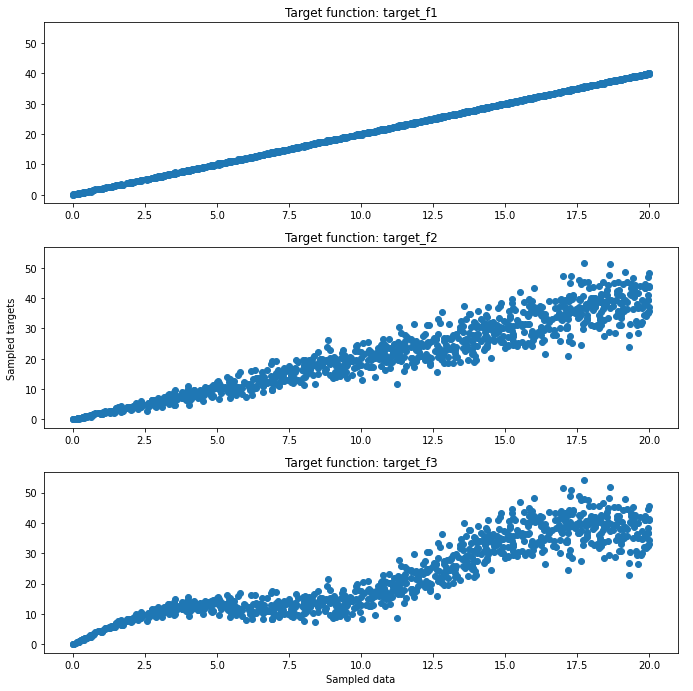

In [123]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 10), sharey=True)
m, n = 1, 1000

for i, target_f in enumerate((target_f1, target_f2, target_f3)):
  x, y = generate_data(target_f=target_f, data_size=n) # TODO: get data for the right function
  axs[i].scatter(x.flatten(), y)
  axs[i].set_title(f"Target function: {target_f.__name__}")


# Plotting code, no need to edit it
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Sampled data")
plt.ylabel("Sampled targets")

fig.tight_layout()
plt.show()

## 3.3 Linear Regression with $\hat{\beta}$ MLE [4 pts]

1. [2 pts] Program the function that computes the maximum likelihood estimate given $X$ and $Y$. Use it to estimate $\hat{\beta}$ for a $n=1000$ sample from each target function.

In [124]:
def beta_mle(X, Y):
  """
  Return the Beta MLE for the linear regression between X and Y.
  """
  # TODO
  beta = jnp.dot(jnp.dot(jnp.linalg.inv(jnp.dot(X, jnp.transpose(X))), X) , Y)
  return beta

2. [2 pt] For each function, plot the linear regression model given by $Y \sim \mathcal{N}(X^\top\beta, \sigma^2 I)$ for $\sigma = 1$. This plot should have the line of best fit given by the maximum likelihood estimate, as well as a shaded region around the line corresponding to plus/minus one standard deviation (i.e. the fixed uncertainty $\sigma = 1.0$). Display 3
plots, one for each target function, showing the data sample and maximum likelihood estimate linear regression model fit to that data.

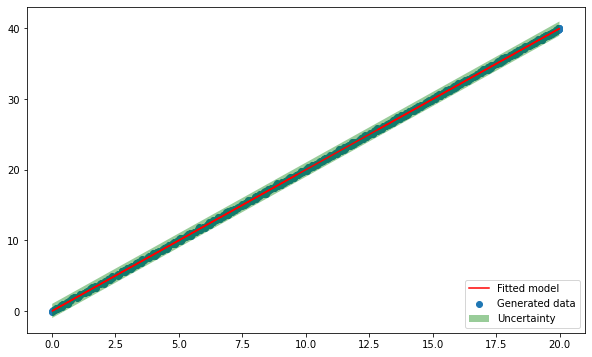

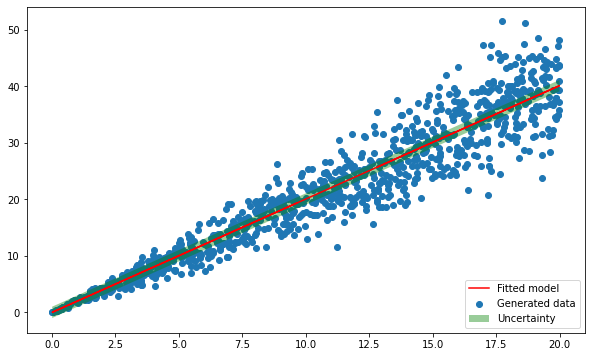

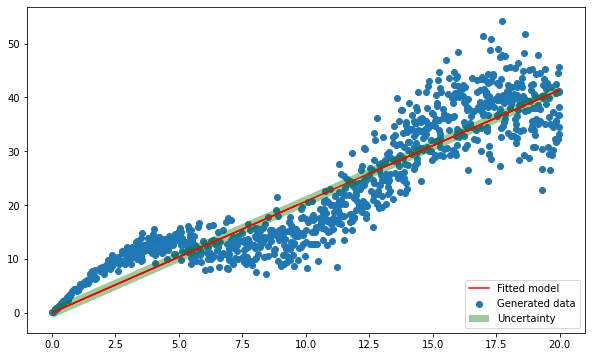

In [125]:
m, n = 1, 1000

for target_f in [target_f1, target_f2, target_f3]:

  x, y = generate_data(target_f=target_f, data_size=n) # TODO, get data from the target function
  beta_estimate = beta_mle(x, y) # TODO fit the regression

  plt.figure(figsize=(10, 6))
  plt.scatter(x.flatten(), y, label="Generated data")
  yhat = x.transpose() @ beta_estimate
  plt.plot(x.flatten(), yhat, label="Fitted model", color="red")

  error_up, error_down = yhat - 1, yhat + 1
  sorted_indices = lax.top_k(x.flatten(), x.shape[1])[1][::-1]
  plt.fill_between(x.flatten()[sorted_indices], 
                  error_down[sorted_indices], error_up[sorted_indices], 
                  facecolor='green', alpha=0.4, label="Uncertainty")

  plt.legend(loc="lower right")
  plt.show()

## 3.4 Log-likelihood of Data Under Model [6 pts]

1. [2 pts] Write code for the function that computes the likelihood of a scalar $x$ under the Gaussian distribution $\mathcal{N}(\mu, \sigma)$. This function should be able to broadcast over $x, \mu, \sigma$.  I.e. it should allow these to be arrays of the same shape, and return an array of likelihoods of the same shape, i.e. $x_i \sim \mathcal{N}(\mu_i, \sigma_i)$.

In [126]:
def gaussian_log_likelihood(mean, stdev, x):
  """
  Compute the gaussian log-likelihood, supporting arguments that are vector or
  matrix valued.
  """
  log_pdf = -0.5 * jnp.log(2 * jnp.pi) - 0.5 * jnp.log(stdev ** 2) - (0.5 / stdev ** 2) * (x - mean) ** 2 # TODO: implement
  return log_pdf

In [127]:
# CHECK YOUR SOLUTION IS RIGHT:

key1, key2 = random.split(key)
x = random.normal(key1)
mean = random.normal(key2)
stdev = random.uniform(key)
log_likelihood = gaussian_log_likelihood(mean, stdev, x)
assert log_likelihood.shape == ()
assert jnp.isclose(log_likelihood, stats.norm.logpdf(x, mean, stdev))

x = random.normal(key1, shape=(100,))
mean = random.normal(key2)
stdev = random.uniform(key)
log_likelihood = gaussian_log_likelihood(mean, stdev, x)
assert log_likelihood.shape == (100,)
assert all(jnp.isclose(implemented, standard, atol=1e-4, rtol=1e-4) for 
           implemented, standard in zip(
               log_likelihood, stats.norm.logpdf(x, mean, stdev)))

x = random.normal(key1, shape=(10,))
mean = random.normal(key2, shape=(10,))
stdev = random.uniform(key, shape=(10,))
log_likelihood = gaussian_log_likelihood(mean, stdev, x)
assert log_likelihood.shape == (10,)

assert all(jnp.isclose(implemented, standard) for 
           implemented, standard in zip(
               log_likelihood, stats.norm.logpdf(x, mean, stdev)))

print("All tests passed")

All tests passed


2. [2 pts] Use your gaussian log-likelihood function to write a function that computes the negative log-likelihood of the target value $Y$ under the model $Y \sim \mathcal{N}(X^\top\beta, \sigma^2 I)$.

In [128]:
def lr_model_nll(beta, x, y, stdev=1.0):
  """
  Return the negative log-likelihood of y given beta.
  """
  # you can ignore these two lines, they just make sure that scalars are treated as vectors
  if beta.ndim is 0:
    beta = jnp.array([beta])
  
  # TODO: implement
  return -1. * gaussian_log_likelihood(jnp.dot(jnp.transpose(x), beta), stdev, y)

3. [1 pts] Use this function to compute and report the negative log-likelihood of a $n = 1000$ batch of data under the model with the maximum-likelihood estimate $\hat{\beta}$ and $\sigma \in \{0.1, 0.3, 1., 2.\}$ for each target function.

In [129]:
n = 1000
for i, target_f in enumerate((target_f1, target_f2, target_f3)):
  fname = target_f.__name__
  print(f"------- target_f: {fname} -------")
  for sig_model in (0.1, 0.3, 1.0, 2.0):
    print(f"------- sigma: {sig_model} -------")

    # TODO: compute negative log likelihood
    x, y = generate_data(target_f, data_size = n, stdev = sig_model)
    beta = beta_mle(x, y)
    nll = lr_model_nll(beta, x, y, stdev = sig_model) # Hint: This should be your last step
  
    print(f"Average Negative Log-Likelihood: {nll.mean()}")

------- target_f: target_f1 -------
------- sigma: 0.1 -------
Average Negative Log-Likelihood: -0.8619210124015808
------- sigma: 0.3 -------
Average Negative Log-Likelihood: 0.2366914302110672
------- sigma: 1.0 -------
Average Negative Log-Likelihood: 1.4406644105911255
------- sigma: 2.0 -------
Average Negative Log-Likelihood: 2.1338117122650146
------- target_f: target_f2 -------
------- sigma: 0.1 -------
Average Negative Log-Likelihood: 648.7440795898438
------- sigma: 0.3 -------
Average Negative Log-Likelihood: 71.95137786865234
------- sigma: 1.0 -------
Average Negative Log-Likelihood: 7.420217037200928
------- sigma: 2.0 -------
Average Negative Log-Likelihood: 3.2374048233032227
------- target_f: target_f3 -------
------- sigma: 0.1 -------
Average Negative Log-Likelihood: 1232.905029296875
------- sigma: 0.3 -------
Average Negative Log-Likelihood: 136.858154296875
------- sigma: 1.0 -------
Average Negative Log-Likelihood: 13.261825561523438
------- sigma: 2.0 -------
A

4. [1 pts] For each target function, what is the best choice of $\sigma$?

for target_f1, $\sigma = 0.1$ is best

for target_f2, $\sigma = 2.0$ is best

for target_f3, $\sigma = 2.0$ is best

YOUR ANSWER HERE: 


## 3.5 Automatic Differentiation and Maximizing Likelihood



In a previous question you derived the expression for the derivative of the negative loglikelihood with respect to $\beta$. We will use that to test the gradients produced by automatic
differentiation.

1. [3 pts] For a random value of $\beta$, $\sigma$, and $n = 100$ sample from a target function, use automatic differentiation to compute the derivative of the negative log-likelihood of the sampled data with respect to $\beta$. Test that this is equivalent to the hand-derived value.

In [130]:
def compute_nll_grad(x, y, beta, sigma):
  """
  Compute the gradient of the negative log-likelihood (hand-derived)
  """
  # you can ignore these two lines, they just make sure that scalars are treated as vectors
  if beta.ndim is 0:
    beta = jnp.array([beta])
  # TODO
  return (-1./sigma**2) * jnp.dot(x, y - jnp.dot(jnp.transpose(x), beta))



def avg_lr_model_nll(beta, x, y, stdev):
  return lr_model_nll(beta, x, y, stdev).mean()

beta_test = random.normal(key)
sigma_test = random.uniform(key, minval=0, maxval=1)
x, y = generate_data(target_f1, 100)

# grad() uses automatic differentiation
ad_grad = grad(avg_lr_model_nll)(beta_test, x, y, sigma_test)
hand_derivative = compute_nll_grad(x, y, beta_test, sigma_test) /100. # dividing by num_sample n to get average

jnp.isclose(ad_grad, hand_derivative)

DeviceArray([ True], dtype=bool)

### 3.5.1 Train Linear Regression Model with Gradient Descent [5 pts]

In this question we will compute gradients of negative log-likelihood with respect to $\beta$. We will use gradient descent to find $\beta$ that maximizes the likelihood.

1. [3 pts] Write a function `train_lin_reg` that accepts a target function and an initial estimate for $\beta$ and some hyperparameters for batch-size, model variance, learning rate, and number of iterations. Then, for each iteration:

- sample data from the target function
- compute gradients of negative log-likelihood with respect to $\beta$ using automatic differentiation
- update the estimate of $\beta$ with gradient descent with specified learning rate 

and, after all iterations, returns the final estimate of $\beta$.

In [131]:
def train_lin_reg(target_f: Callable, initial_beta, 
                  model_variance: float, learning_rate: float, num_iter: int):
  """
  Train the linear regression model using the given parameters.
  """
  # TODO
  batch_size = 100
  beta = initial_beta
  for i in range(num_iter):
    x, y = generate_data(target_f=target_f, data_size = batch_size, stdev = jnp.sqrt(model_variance))
    gradient = grad(avg_lr_model_nll)(beta, x, y, stdev = jnp.sqrt(model_variance))
    beta -= learning_rate * gradient
  return beta

2. [2 pts] For each target function, start with an initial parameter $\beta$, learn an estimate for $\beta_{\text{learned}}$ by gradient descent. Then plot a $n = 1000$ sample of the data and the learned linear regression model with shaded region for uncertainty corresponding to plus/minus one standard deviation.

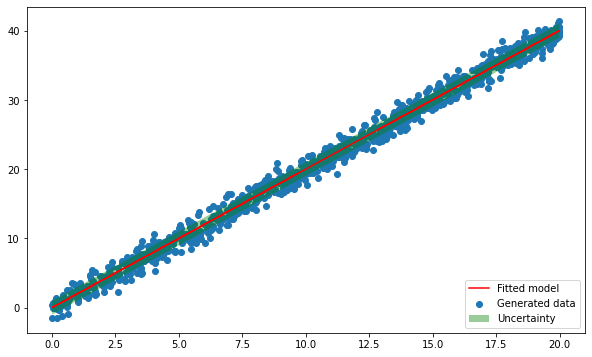

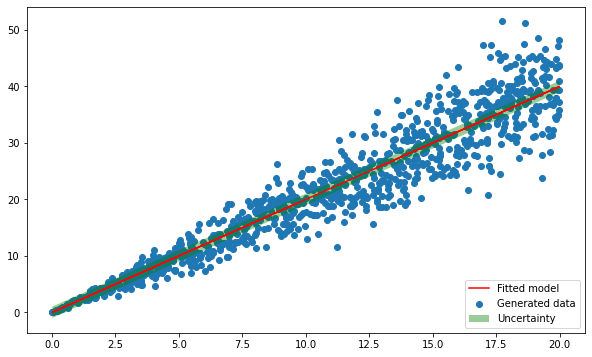

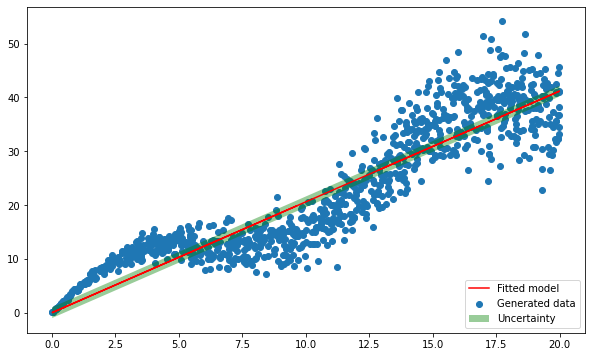

In [132]:
for target_function in [target_f1, target_f2, target_f3]:
  
  initial_beta = random.uniform(key, minval = 1, maxval =10) # TODO sample a random beta
  fitted_beta = train_lin_reg(target_function, initial_beta=initial_beta, model_variance = 1, learning_rate = 0.001, num_iter = 50)# TODO fit the linear regression
  fitted_beta = jnp.array([fitted_beta])

  # Plotting code (you don't need to edit it)
  plt.figure(figsize=(10, 6))
  x, y = generate_data(target_function, 1000, 1.0)
  plt.scatter(x.flatten(), y, label="Generated data")
  yhat = x.transpose() @ fitted_beta
  plt.plot(x.flatten(), yhat, label="Fitted model", color="red")

  error_up, error_down = yhat - 1, yhat + 1
  
  sorted_indices = lax.top_k(x.flatten(), x.shape[1])[1][::-1]
  plt.fill_between(x.flatten()[sorted_indices], 
                  error_down[sorted_indices], error_up[sorted_indices], 
                  facecolor='green', alpha=0.4, label="Uncertainty")

  plt.legend(loc="lower right")
  plt.show()

### 3.5.2 Non-linear regression with a Neural Network [5 pts]

In the previous questions we have considered a linear regression model 

$$ Y \sim \mathcal{N}(X^\top \beta, \sigma^2 I) $$

This model specified the mean of the prediction distribution for each distribution by the product of that datapoint with our parameter.

Now, let us generalize this to consider a model where the mean of the predictive distribution
is a non-linear function of each datapoint. We will have our non-linear model be a simple
function called neural net with parameters $\theta$ (collection of weights and biases).

$$Y \sim \mathcal{N}(\text{neural_net}(X, \theta), \sigma^2)$$

The code for a fully-connected neural network (multi-layer perceptron) with one 10-dimensional hidden layer and a tanh nonlinearirty. You must write this yourself using only basic operations like matrix multiply and tanh, you may not use layers provided by a library. This network will output the mean vector, test that it outputs the correct shape for some random parameters.

In [133]:
def neural_network(x, theta):
  """
  Compute the forward pass of a neural network with 1 hidden layer consisting
  of 10 hidden neurons and a tanh nonlinear activation.
  """
  n = x.shape[-1]
  input_to_hidden_weights = theta["input_hidden_w"]
  hidden_to_output_weights = theta["hidden_out_w"]
  input_to_hidden_bias = theta["input_hidden_b"]
  hidden_to_output_bias = theta["hidden_out_b"]


  outputs = jnp.tanh(x.transpose() @ input_to_hidden_weights + 
                     input_to_hidden_bias)
  
  return outputs @ hidden_to_output_weights + hidden_to_output_bias

In [134]:
n = 100
x, y = generate_data(target_f1, n)

theta = {
    "input_hidden_w": random.normal(key, shape=(1, 10)),
    "hidden_out_w": random.normal(key, shape=(10,)),
    "input_hidden_b": random.normal(key, shape=(10,)),
    "hidden_out_b": random.normal(key, shape=(1,))
}

mean = neural_network(x, theta)
assert mean.shape == (n,)

2. [1pts] Write the code that computes the negative log-likelihood for this model where the mean is given by the output of the neural network and $\sigma = 1.0$

In [135]:
def nn_model_nll(theta, x, y, sigma=1.0):
  """
  Compute the negative log-likelihood for the model where the mean is the output
  of the neural network.
  """
  mean = neural_network(x, theta) # TODO get neural network output
  stdev_arg = jnp.ones(y.flatten().shape) * sigma

  return -gaussian_log_likelihood(mean, stdev_arg, y)

3. [2 pts] Write a function `train_nn_reg` that accepts a target function and an initial estimate for $\theta$ and some hyperparameters for batch-size, model variance, learning rate, and number of iterations. Then, for each iteration:

- sample data from the target function
- compute gradients of negative log-likelihood with respect to $\theta$
- update the estimate of $\theta$ with gradient descent with specified learning rate

and, after all iterations, returns the final estimate of $\theta$.

In [136]:
def avg_nn_model_nll(theta, x, y, sigma=1.0):
  return nn_model_nll(theta, x, y, sigma).mean()
  
def train_nn_reg(target_f: Callable, initial_theta,
                 model_variance: float = 1.0, learning_rate: float= 1e-3, num_iter: int=5000
                 ):
  """
  Train the linear regression model using the given parameters.
  """
  theta = initial_theta
  
  sigma = model_variance ** (1/2)

  log_frequency = int(jnp.ceil(0.1 * num_iter))

  model_nll_grad = grad(avg_nn_model_nll)
  
  for i in range(num_iter):
    x, y = generate_data(target_f=target_f, data_size = 100, stdev = sigma)
    avg_neg_log_like = avg_nn_model_nll(theta, x, y, sigma)# TODO: compute average negative log likelihood
    if i % log_frequency == 0:
      print(f"[Iteration {i + 1}] Loss: {avg_neg_log_like}")

    grad_theta = grad(avg_nn_model_nll)(theta, x, y, sigma = sigma) # TODO: compute gradient here
    # Hint: use the grad() function
    
    theta["input_hidden_w"] -= learning_rate * grad_theta["input_hidden_w"]
    theta["hidden_out_w"] -= learning_rate * grad_theta["hidden_out_w"]
    theta["input_hidden_b"] -= learning_rate * grad_theta["input_hidden_b"]
    theta["hidden_out_b"] -= learning_rate * grad_theta["hidden_out_b"]

  return theta

4. [2pts] For each target function, start with an initialization of the network parameters, $\theta$, use your train function to minimize the negative log-likelihood and find an estimate for $\theta$ learned by gradient descent. Then plot a $n = 1000$ sample of the data and the learned regression model with shaded uncertainty bounds given by $\sigma = 1.0$.

[Iteration 1] Loss: 188.87362670898438
[Iteration 501] Loss: 12.580802917480469
[Iteration 1001] Loss: 6.561192035675049
[Iteration 1501] Loss: 7.26894998550415
[Iteration 2001] Loss: 7.105722427368164
[Iteration 2501] Loss: 6.721976280212402
[Iteration 3001] Loss: 6.344025611877441
[Iteration 3501] Loss: 5.994722366333008
[Iteration 4001] Loss: 5.657977104187012
[Iteration 4501] Loss: 5.258012771606445


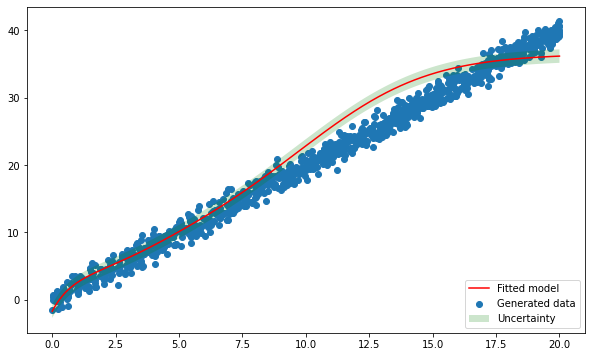

[Iteration 1] Loss: 10.083444595336914
[Iteration 501] Loss: 9.133792877197266
[Iteration 1001] Loss: 8.962111473083496
[Iteration 1501] Loss: 8.762982368469238
[Iteration 2001] Loss: 8.57912826538086
[Iteration 2501] Loss: 8.417296409606934
[Iteration 3001] Loss: 8.278407096862793
[Iteration 3501] Loss: 8.161638259887695
[Iteration 4001] Loss: 8.064867973327637
[Iteration 4501] Loss: 7.9852824211120605


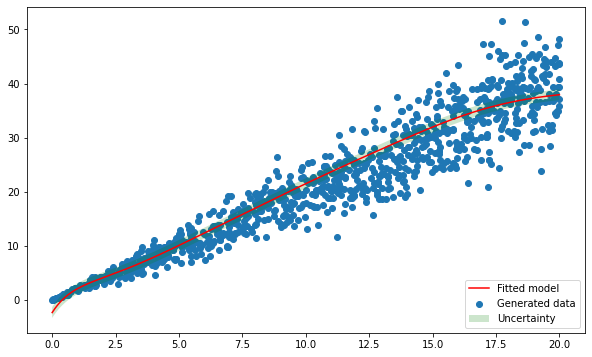

[Iteration 1] Loss: 11.845053672790527
[Iteration 501] Loss: 11.54041862487793
[Iteration 1001] Loss: 9.804365158081055
[Iteration 1501] Loss: 8.996606826782227
[Iteration 2001] Loss: 8.46694564819336
[Iteration 2501] Loss: 8.091827392578125
[Iteration 3001] Loss: 7.7384352684021
[Iteration 3501] Loss: 7.455477237701416
[Iteration 4001] Loss: 7.28864049911499
[Iteration 4501] Loss: 7.262598514556885


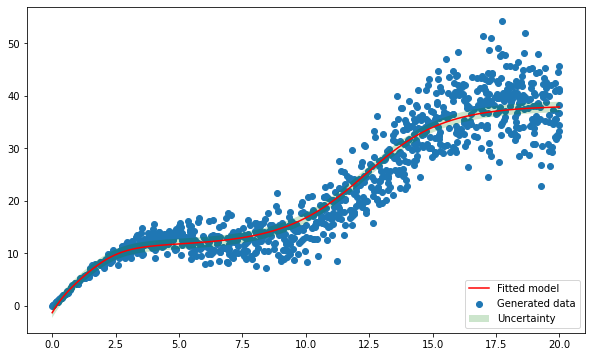

In [137]:

initial_theta = {
    "input_hidden_w": random.normal(key, shape=(1, 10)),
    "hidden_out_w": random.normal(key, shape=(10,)),
    "input_hidden_b": random.normal(key, shape=(10,)),
    "hidden_out_b": random.normal(key, shape=(1,))
}

for target_function in [target_f1, target_f2, target_f3]:

  fitted_params = train_nn_reg(target_f=target_function, initial_theta=initial_theta) # TODO: fit a neural network to your data
  
  # Plotting code, you don't need to edit this
  plt.figure(figsize=(10, 6))
  x, y = generate_data(target_function, 1000, 1.0)
  plt.scatter(x.flatten(), y, label="Generated data")
  plot_x = np.linspace(0, 20, 1000)
  nn_preds = neural_network(plot_x.reshape(1, 1000), fitted_params)
  plt.plot(plot_x, nn_preds, label="Fitted model", color="red")

  error_up, error_down = nn_preds + 1, nn_preds - 1
  plt.fill_between(plot_x, 
                  error_down, error_up, 
                  facecolor='green', alpha=0.2, label="Uncertainty")

  plt.legend(loc="lower right")
  plt.show()